<a href="https://colab.research.google.com/github/Vahe0795/Machine-Learning/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
df = pd.read_csv('comments.tsv', sep='\t')
X = df['comment_text']
y = df['should_ban']



In [3]:
from pandas.core.common import random_state
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42, stratify=y)


In [4]:
from nltk.tokenize import TweetTokenizer

def preprocess(t):
    t = t.lower()
    token = TweetTokenizer()
    return " ".join(token.tokenize(t))


text = 'How to be a grown-up at work: replace "fuck you" with "Ok, great!".'

print("before:", text)
print("after:", preprocess(text))

before: How to be a grown-up at work: replace "fuck you" with "Ok, great!".
after: how to be a grown-up at work : replace " fuck you " with " ok , great ! " .


In [5]:
texts_train = [preprocess(i) for i in X_train]
texts_test = [preprocess(i) for i in X_test]

In [6]:
assert texts_train[3] ==  'butts screw my butthole mr krabs'
assert texts_test[5] == ', 21 april 2008 ( utc ) what the fuck are you talking about ? 11:47'
assert len(texts_test) == len(y_test)

In [7]:
from collections import Counter 
c = Counter(' '.join(texts_train).split())
k = 10000
bow_vocabulary = c.most_common(k)
bow_vocabulary = [i[0] for i in bow_vocabulary]
print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '1890-1920', '442', 'absurd', 'african', 'annon', 'articulate', 'bam', 'bing', 'brotherhood', 'cats', 'cking', 'concerns', 'costs', 'dates', 'diary', 'dont', 'eisenhower', 'even', 'faking', 'flavor', 'fulfill', 'goddamn', 'happened', 'historic', 'identifies', 'inherently', 'jane', 'lacking', 'listen', 'managers', 'mexico', 'moved', 'nobody', 'oh', 'particular', 'piss', 'presence', 'psychics', 'reach', 'relating', 'reversion', 'say', "she's", 'smuggling', 'standard', 'suckin', 'taunted', 'threaten', 'tries', 'unless', 'view', 'wen', 'world', '•']


In [8]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    token_counts = [[] for i in range(len(text))]
    index = 0
    for i in text:
        for j in bow_vocabulary:
            if j in i.split():
                if len(bow_vocabulary) > len(token_counts[index]):
                    token_counts[index].append(i.split().count(j))
            else:
                token_counts[index].append(0)
        if len(bow_vocabulary) == len(token_counts[index]) and index != len(token_counts) - 1:
            index += 1
    return np.array(token_counts, 'float32')

In [9]:
X_train_bow = text_to_bow(texts_train)
X_test_bow = text_to_bow(texts_test)


In [10]:
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, mean_squared_error

bow_model = LogisticRegression()
bow_model.fit(X_train_bow, y_train)
y_pred = bow_model.predict(X_test_bow)

print(f'f1_score: {f1_score(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')

f1_score: 0.7889546351084813
MSE: 0.214


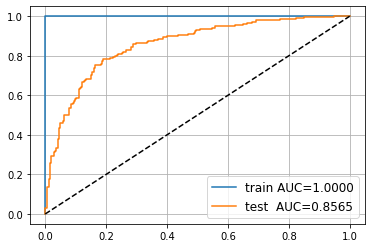

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

In [13]:
import gensim.downloader 
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
def vectorize_sum(comment, embedding_dim):

    embedding_dim = embeddings.wv.vectors.shape[1]
    keys = embeddings.index_to_key 
    does_not_exist = np.zeros([embedding_dim], dtype='float32')
    features = sum([embeddings.get_vector(word) if word in keys else does_not_exist for word in comment.split()])
    
    return features

assert np.allclose(
    vectorize_sum(comment="who cares anymore . they attack with impunity .", embedding_dim=300)[::70],
    np.array([ 0.0108616 ,  0.0261663 ,  0.13855131, -0.18510573, -0.46380025])
)

In [ ]:
extra = "'"
preprocess = lambda text: ' '.join([word.split(extra)[0] if extra in word else word for word in text.split()])
        
texts_test = np.array([preprocess(text) for text in texts_test])
texts_train = np.array([preprocess(text) for text in texts_train])

In [ ]:
X_train_wv = np.stack([vectorize_sum(comment=text, embedding_dim=300) for text in texts_train])
X_test_wv = np.stack([vectorize_sum(comment=text, embedding_dim=300) for text in texts_test])

In [ ]:
wv_model = LogisticRegression(max_iter=1000).fit(X_train_wv, y_train)

for name, X, y, model in [
    ('bow train', X_train_bow, y_train, bow_model),
    ('bow test ', X_test_bow, y_test, bow_model),
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

assert roc_auc_score(y_test, wv_model.predict_proba(X_test_wv)[:, 1]) > 0.92, "something's wrong with your features"

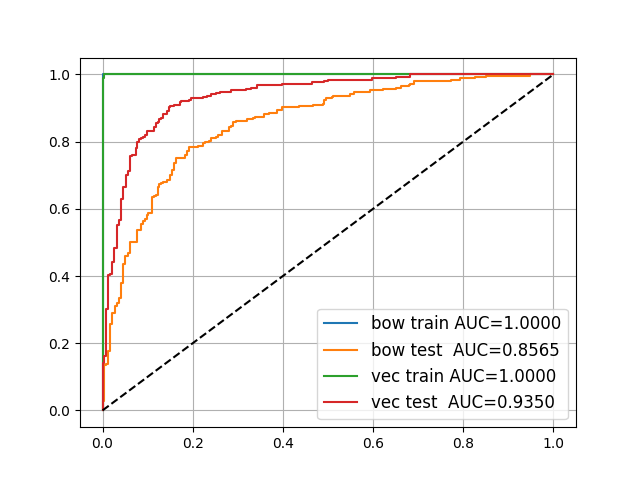